In [59]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')
df_search_tags = pd.read_csv('../Datasets/search_tag_embeddings.csv')

In [60]:

# Merge embeddings with the main dataset (df) based on advertiser name
df = df.merge(df_advertiser, on="advertiser_name", how="left")

In [61]:
# Define the indices to drop
rows_to_remove = [69130, 69131, 69132, 69133, 69134, 69135]

# Drop the rows
df = df.drop(index=rows_to_remove, errors='ignore')

In [62]:
df_keywords = df_keywords.drop(index=rows_to_remove, errors='ignore')
df_search_tags = df_search_tags.drop(index=rows_to_remove, errors='ignore')

In [63]:
print(df)

       campaign_item_id  no_of_days  ext_service_id  creative_id  template_id  \
0                  2733    0.059322             128         1000         90.0   
1                  2733    0.067797              16         1000         90.0   
2                  2733    0.076271             128         1000         90.0   
3                  2733    0.084746             128         1000         90.0   
4                  2733    0.093220               4         1000         90.0   
...                 ...         ...             ...          ...          ...   
69195              3960    0.016949             128        13710         90.0   
69196              3960    0.025424             128        13710         90.0   
69197              3960    0.033898             128        13710         90.0   
69198              3960    0.042373             128        13710         90.0   
69199              3960    0.050847              16        13710         90.0   

       advertiser_id advert

In [64]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days', 'is_weekday']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['plateform_DV360', 'plateform_Facebook Ads', 'plateform_Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['channel_Display', 'channel_Mobile', 
                   'channel_Search', 'channel_Social', 'channel_Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


currency_data = df[['currency_AED', 'currency_EGP', 'currency_INR', 'currency_SGD', 'currency_USD']]
# Convert to tensor format
currency_features = torch.tensor(currency_data.values, dtype=torch.float)
# data['currency'] is the currency node feature storage
data['currency'].x = currency_features


creative_data = df[['has_image']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


keyword_data = df_keywords[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


advertiser_id = df[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features


search_tags_data = df_search_tags[[f'search_tag_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
search_tag_features = torch.tensor(search_tags_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['search_tag'].x = search_tag_features


In [65]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)


data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # channel indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)


# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# # # Edges (Creative → Template)
# data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
#     [0, 1],  # creative indices
#     [0, 1]   # template indices
# ], dtype=torch.long)


data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


# data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
#     [0, 1],  # campaign indices
#     [0, 1]   # channel indices
# ], dtype=torch.long)


data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

# Edges (Campaign → Search Tag)
data['campaign', 'targeted_with', 'search_tag'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # search tag indices
], dtype=torch.long)

data['search_tag', 'rev_targeted_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # search tag indices
    [0, 1]   # campaign indices
], dtype=torch.long)


# The corresponding click values for each record
click_values = torch.tensor(df['clicks_normalized'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")

clicks shape: torch.Size([69194])


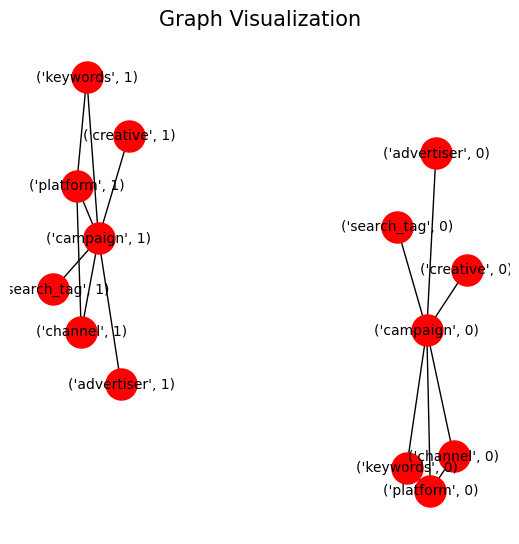

In [66]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [67]:
from torch_geometric.utils import is_undirected, contains_self_loops
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            # ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            # ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            # ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            # ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        self.conv3 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv((-1, -1), hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv((-1, -1), hidden_dim),
            # ('creative', 'designed_with','template'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            # ('campaign', 'managed_by', 'network'): SAGEConv((-1, -1), hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv((-1, -1), hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv((-1, -1), hidden_dim),
            ('campaign', 'targeted_with', 'search_tag'): SAGEConv((-1, -1), hidden_dim),
            ('search_tag', 'rev_targeted_with', 'campaign'): SAGEConv((-1, -1), hidden_dim)
        }, aggr="mean")

        # 🔹 Add LayerNorm for stability
        self.norm1 = torch.nn.LayerNorm(hidden_dim)
        self.norm2 = torch.nn.LayerNorm(hidden_dim)
        self.norm3 = torch.nn.LayerNorm(hidden_dim)

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 7, 1)  # Concatenating features from 6 node types

        

    def forward(self, x_dict, edge_index_dict):

        # 🔹 Apply first convolution
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: self.norm1(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply second convolution
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: self.norm2(x) for key, x in x_dict.items()}  # 🔹 Normalize
        x_dict = {key: F.leaky_relu(x, negative_slope=0.01) for key, x in x_dict.items()}

        # 🔹 Apply third convolution
        x_dict = self.conv3(x_dict, edge_index_dict)
        x_dict = {key: self.norm3(x) for key, x in x_dict.items()}  # 🔹 Normalize
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'], x_dict['keywords'], 
                                x_dict['search_tag'], x_dict['advertiser']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out


In [68]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

# Get indices for campaigns (assuming 'campaign' nodes are being predicted)
campaign_indices = torch.arange(data.x_dict['campaign'].size(0))

# 80% Train, 20% Test Split
train_idx, test_idx = train_test_split(campaign_indices.cpu().numpy(), test_size=0.2, random_state=42)

# Convert to tensors
train_idx = torch.tensor(train_idx, dtype=torch.long, device=device)
test_idx = torch.tensor(test_idx, dtype=torch.long, device=device)

In [69]:

# Initialize model
model = HeteroGCN(hidden_dim=32)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by 50% every 50 epochs



num_epochs = 80
best_mse = float('inf')
patience = 50
counter = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass on training data (only train nodes)
    out = model(data.x_dict, data.edge_index_dict)
    train_loss = F.mse_loss(out.squeeze()[train_idx], click_values[train_idx])

    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    # 🔹 Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(data.x_dict, data.edge_index_dict)  # No need for a separate test_data
        test_loss = F.mse_loss(test_out.squeeze()[test_idx], click_values[test_idx])

    test_losses.append(test_loss.item())

    print(f"Epoch {epoch}, Train MSE: {train_loss.item():.4f}, Test MSE: {test_loss.item():.4f}")


HeteroGCN(
  (conv1): HeteroConv(num_relations=11)
  (conv2): HeteroConv(num_relations=11)
  (conv3): HeteroConv(num_relations=11)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=224, out_features=1, bias=True)
)
Epoch 0, Train MSE: 0.1809, Test MSE: 0.1977
Epoch 1, Train MSE: 0.1971, Test MSE: 0.1438
Epoch 2, Train MSE: 0.1434, Test MSE: 0.0298
Epoch 3, Train MSE: 0.0300, Test MSE: 0.0592
Epoch 4, Train MSE: 0.0599, Test MSE: 0.0975
Epoch 5, Train MSE: 0.0982, Test MSE: 0.0597
Epoch 6, Train MSE: 0.0602, Test MSE: 0.0140
Epoch 7, Train MSE: 0.0142, Test MSE: 0.0154
Epoch 8, Train MSE: 0.0155, Test MSE: 0.0417
Epoch 9, Train MSE: 0.0418, Test MSE: 0.0456
Epoch 10, Train MSE: 0.0457, Test MSE: 0.0232
Epoch 11, Train MSE: 0.0233, Test MSE: 0.0038
Epoch 12, Train MSE: 0.0039, Test MSE: 0.0063
Epoch 13, Train MSE: 0.0064,

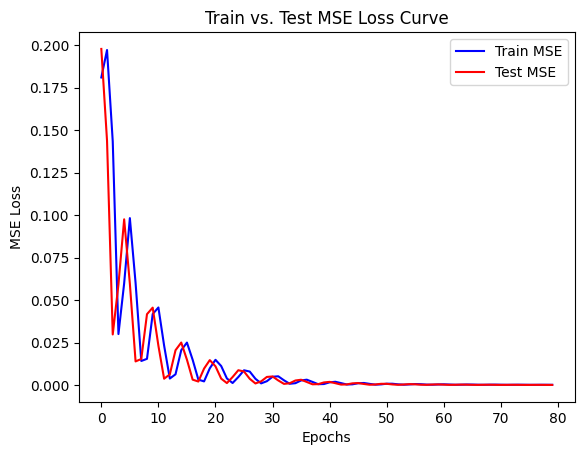

In [70]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, label="Train MSE", color='blue')
plt.plot(range(len(test_losses)), test_losses, label="Test MSE", color='red')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Train vs. Test MSE Loss Curve")
plt.show()


In [71]:
import torch.nn.functional as F

def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Move data to the correct device
        data = data.to(device)
        click_values = click_values.to(device)
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        # Ensure shapes match
        out = out.view(-1)  # Flatten predictions if necessary
        click_values = click_values.view(-1)  # Flatten actual values if necessary
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out, click_values)  
        return mse.item()
    
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
mse_score = evaluate_model(model, data, click_values, device)
print(f"Test MSE: {mse_score:.4f}")


Test MSE: 0.0002


In [72]:
def r_squared(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    
    return 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero

# Unscale predictions before calculating R²
predictions = model(data.x_dict, data.edge_index_dict).squeeze()
predictions = predictions * click_values.max()  # Reverse Min-Max Scaling

# Compute R²
r2_score = r_squared(click_values, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: -1.6269


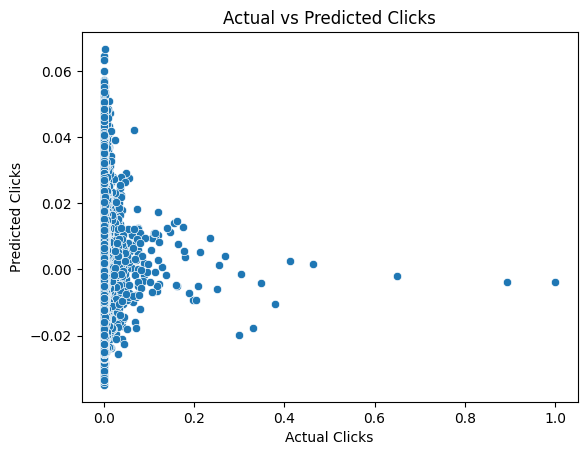

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=click_values.cpu().numpy(), y=predictions.cpu().detach().numpy())
plt.xlabel("Actual Clicks")
plt.ylabel("Predicted Clicks")
plt.title("Actual vs Predicted Clicks")
plt.show()


In [74]:
model.eval()
with torch.no_grad():
    predictions = model(data.x_dict, data.edge_index_dict).squeeze()[test_idx]

print("Actual vs Predicted Clicks:")
for actual, predicted in zip(click_values[test_idx][:10].tolist(), predictions[:10].tolist()):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")


Actual vs Predicted Clicks:
Actual: 0.0012, Predicted: 0.0040
Actual: 0.0002, Predicted: -0.0097
Actual: 0.0001, Predicted: 0.0189
Actual: 0.0000, Predicted: -0.0090
Actual: 0.0002, Predicted: 0.0001
Actual: 0.0001, Predicted: 0.0053
Actual: 0.0000, Predicted: -0.0087
Actual: 0.0001, Predicted: -0.0021
Actual: 0.0001, Predicted: -0.0108
Actual: 0.0003, Predicted: -0.0090


In [75]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Predicted clicks for new campaign: 0.01754983887076378


In [ ]:
# Assuming `data` is your existing graph data with pre-trained node embeddings

# New data for prediction (Only adding a few relevant nodes)
new_campaign = torch.tensor([[157, 0.54, 1]], dtype=torch.float)  # New campaign feature
new_platform = torch.tensor([[0, 1, 0]], dtype=torch.float)        # New platform feature
new_channel = torch.tensor([[0, 0, 0, 0, 1]], dtype=torch.float)    # New channel feature
new_keywords = torch.rand((1, 50), dtype=torch.float)               # New keywords feature

# Add the new nodes to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)

# Get indices for the new nodes
new_campaign_index = data['campaign'].x.size(0) - 1
new_platform_index = data['platform'].x.size(0) - 1
new_channel_index = data['channel'].x.size(0) - 1
new_keywords_index = data['keywords'].x.size(0) - 1

# Add only necessary edges, utilizing pre-existing nodes
# Example: Connecting new campaign to an existing platform (e.g., platform index 0)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [data['campaign', 'hosted_on', 'platform'].edge_index,
     torch.tensor([[new_campaign_index], [new_platform_index]], dtype=torch.long)], dim=1
)

data['campaign', 'uses', 'channel'].edge_index = torch.cat(
    [data['campaign', 'uses', 'channel'].edge_index,
     torch.tensor([[new_campaign_index], [new_channel_index]], dtype=torch.long)], dim=1
)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.cat(
    [data['campaign', 'associated_with', 'keywords'].edge_index,
     torch.tensor([[new_campaign_index], [new_keywords_index]], dtype=torch.long)], dim=1
)

# Optional: Connect to pre-existing advertiser without re-inputting
existing_advertiser_index = 5  # Example: use an existing advertiser node
data['campaign', 'belongs_to', 'advertiser'].edge_index = torch.cat(
    [data['campaign', 'belongs_to', 'advertiser'].edge_index,
     torch.tensor([[new_campaign_index], [existing_advertiser_index]], dtype=torch.long)], dim=1
)

# Make predictions using the updated graph
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)
    new_prediction = output['campaign'][new_campaign_index]
    predicted_class = new_prediction.argmax().item()

print(f"Predicted engagement class: {predicted_class}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 69196 but got size 69194 for tensor number 3 in the list.

In [ ]:
torch.save(model.state_dict(), "sage_model.pth")  # ✅ Save only weights
